# QS Ranking Methodology

This project investigates the QS university ranking methodology by testing whether the published factor weights (employability, research output, student–faculty ratio, international students, etc.) align with real data. Using a linear regression model on available university data, the project estimates factor contributions and compares them to the official QS weights, while noting limitations due to missing factors in the dataset.

The methodology of the QS Ranking: https://www.topuniversities.com/world-university-rankings/methodology

The dataset taken from: https://www.kaggle.com/datasets/zulqarnain11/global-university-rankings-2025-2026/data

## Import the neccessary tools

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Overview of the dataset

In [34]:
df = pd.read_csv("university-rankings.csv")
df.head()

,Country,University_Name,World_Rank,National_Rank,QS_Rank,THE_Rank,ARWU_Rank,Enrollment,Undergrad_Students,Postgrad_Students,Faculty_Count,Student_Faculty_Ratio,Research_Output,International_Students (%),Tuition_Fee_USD,Acceptance_Rate (%),Graduation_Rate (%),Employability_Rank,QS_Subject_Rank
0,United States,Massachusetts Institute of Technology (MIT),1,1,1,2,3,11836,4657,7179,1479,8.0,Very High,33,59750,4,98,1,1
1,United Kingdom,University of Oxford,2,1,4,1,6,22095,12510,9585,2045,10.8,Very High,43,45000,17,96,3,2
2,United States,Stanford University,3,2,3,6,2,16963,7087,9876,2875,5.9,Very High,23,61731,4,94,2,3
3,United States,Harvard University,4,3,5,3,1,22584,7153,15431,2258,10.0,Very High,25,57261,3,97,4,4
4,United Kingdom,University of Cambridge,5,2,6,5,4,20980,12940,8040,1824,11.5,Very High,38,48000,21,97,5,5


## The factors in use:
1. <i><b>Research_Output</b></i> – qualitative assessment of research productivity (e.g., Very High, High).
2. <i><b>Employability_Rank</b></i> – global rank based on graduate employability outcomes.
3. <i><b>Student_Faculty_Ratio</b></i> – the ratio of students to academic staff members.
4. <i><b>International_Students</b></i> (%) – percentage of the student body that are international students.
5. <i><b>QS_Rank</b></i> – the specific rank in the QS World University Rankings 2026.

## Let's rename the column for convenience

In [54]:
df = df.rename(columns={
    'International_Students (%)': 'International_Students'
})

## Handle the categorical values

In [55]:
df["Research_Output"].unique()

<StringArray>
['Very High', 'High', 'Medium']
Length: 3, dtype: str

In [56]:
research_map = {
    "Medium": 1,
    "High": 2,
    "Very High": 3
}

df["Research_Output_encoded"] = df["Research_Output"].map(research_map)

## Handle the values representing ranks

Since the dataset does not contain the actual scores used to derive the ranks, we will try to create our own scores by using the ranking. Such approach will not yield very accurate results but it will be sufficient for eyeballing the effect of each variable on the ranking of a university.

In [57]:
employability_max = df["Employability_Rank"].max()

df["Employability_Score"] = employability_max - df["Employability_Rank"] + 1

In [58]:
qs_max = df["QS_Rank"].max()

df["QS_Score"] = qs_max - df["QS_Rank"] + 1

## Extract the neccessary columns from the dataframe and split the data into training and testing data

In [60]:
factors = [
    "Research_Output_encoded",
    "Employability_Score",
    "Student_Faculty_Ratio",
    "International_Students"
]

X = df[factors]
y = df["QS_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

## Normalize the values using StandardScaler

In [61]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fit the model using the training data

In [62]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


## Let's check the coefficients of the model

In [67]:
coefficients = pd.Series(model.coef_, index=features)

In [70]:
coefficients

Research_Output_encoded        12.492043
Employability_Score           274.903226
Student_Faculty_Ratio          -0.369350
International_Students (%)      0.317466
dtype: float64

<Axes: >

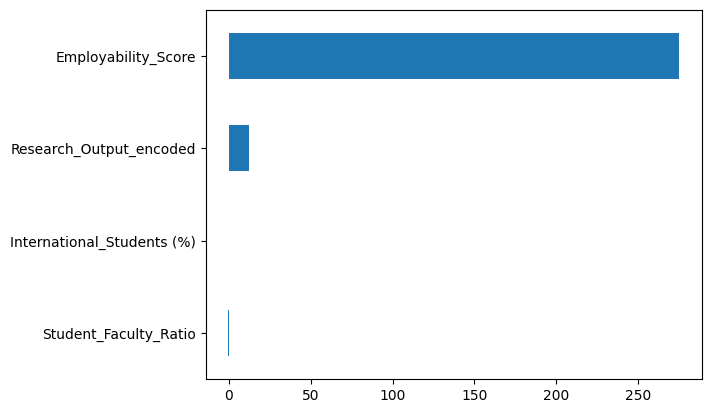

In [73]:
coefficients.sort_values().plot(kind="barh")

## Interpretation:

As evidenced by a large positive coefficient of 274.9, the QS ranking of a university is mainly determined by the employability of university students. The second most significant variable is the research output. This is against what QS Ranking says about the weight of these variables in determining the university rankings (see more: https://www.topuniversities.com/world-university-rankings/methodology). However, we shouldn't overlook the fact that this study did not use the actual qs university scores or employability scores; the position of universities (ranking) were used instead. This has probably caused a distribution of weights among the used variables that is inconsistent with the distribution of QS Ranking.

## Testing

Nevertheless, the trained model is doing a pretty good job in predicting the rankings of the universities.

In [77]:
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

R²: 0.9910302943061445


## Comparison of Actual QS Ranks and Predicted QS Ranks

In [79]:
test_results = X_test.copy()
test_results["Actual_QS_Score"] = y_test.values
test_results["Predicted_QS_Score"] = y_pred

test_results["Actual_Rank"] = (
    test_results["Actual_QS_Score"]
    .rank(ascending=False)
)

test_results["Predicted_Rank"] = (
    test_results["Predicted_QS_Score"]
    .rank(ascending=False)
)

In [84]:
test_results[["Actual_Rank", "Predicted_Rank"]].head(15)

,Actual_Rank,Predicted_Rank
778,149.0,151.0
334,59.5,50.0
271,45.0,39.0
802,156.5,159.0
216,38.0,35.0
408,75.0,73.0
812,160.0,162.0
94,17.0,15.0
487,88.5,85.0
170,31.0,25.0
